In [1]:
import os
from pyo import *

################
# SYNTHÉTISEUR #
################

def simple_synth(nom_fichier, params):
    """
    Génère un fichier audio basé sur les paramètres fournis.
    
    params : dictionnaire contenant la configuration du synthé.
    """
    
    s = Server(audio='offline')
    s.boot()
    
    duree_totale = params['duree'] + params['env_release']
    s.recordOptions(dur=duree_totale, filename=nom_fichier, fileformat=0, sampletype=0)

    # - OSCILLATEUR
    # LFO est utilisé ici comme oscillateur audio car il permet de changer 
    # la forme d'onde facilement via un numéro (0=Sine, 1=Rect, 2=Tri, 3=Saw, etc.)
    # type 3 = Saw (Dents de scie), type 1 = Pulse/Square
    osc = LFO(freq=params['osc_freq'], sharp=1, type=params['osc_type'], mul=params['osc_vol'])

    # - NOISE
    # Bruit blanc mélangé au signal
    noise = Noise(mul=params['noise_vol'])

    # Mixage Oscillateur + Bruit
    source_mix = osc + noise

    # - FILTRE
    # filtre multimode
    # type 0 = Lowpass, 1 = Highpass, 2 = Bandpass
    filt = Biquadx(source_mix, freq=params['filter_cutoff'], q=params['filter_res'], type=params['filter_type'])

    # - ENVELOPPE ADSR
    env = Adsr(attack=params['env_attack'], 
               decay=params['env_decay'], 
               sustain=params['env_sustain'], 
               release=params['env_release'], 
               dur=params['duree'],
               mul=params['master_vol'])
    
    # Application de l'enveloppe sur le signal filtré
    signal = filt * env
    panner = Pan(signal, outs=2, pan=0.5) 
    panner.out()

    # - RENDU
    env.play() # Déclenche l'enveloppe
    s.start()  # Lance le calcul audio
    
    # Nettoyage
    s.shutdown()


WxPython is not found for the current python version.
Pyo will use a minimal GUI toolkit written with Tkinter (if available).
This toolkit has limited functionnalities and is no more
maintained or updated. If you want to use all of pyo's
GUI features, you should install WxPython, available here:
http://www.wxpython.org/



In [2]:
##################
# EXEMPLE PRESET #
##################

parametres_synthe = {
    'duree': 1.0,           

    'osc_freq': 210.0,      # Fréquence (Hz)
    'osc_type': 0,          # 0=Saw Up, 1=Saw Down, 2=Square, 3=Triangle, 4=Pulse, 5=Bipolar Pulse, 7=Modulated Sine
    'osc_vol': 0.6,         # Volume de l'osc (0.0 à 1.0)
    
    'noise_vol': 0.1,       # Quantité de bruit (0.0 pour un son pur)
    
    'filter_type': 2,       # 0=LowPass, 1=HighPass, 2=BandPass
    'filter_cutoff': 800,   # Fréquence de coupure (Hz)
    'filter_res': 1.5,      # Résonance
    
    'env_attack': 0.05,     # Attaque (sec)
    'env_decay': 0.2,       # Decay (sec)
    'env_sustain': 0.7,     # Sustain (niveau 0.0 à 1.0)
    'env_release': 0.5,     # Release (sec)
    
    'master_vol': 0.8       # Volume (0.0 à 1.0)
}

# Génération
nom_sortie = "example.wav"
filepath = os.path.join("wavs", nom_sortie)
simple_synth(filepath, parametres_synthe)
print("example.wav enregistré dans le dossier 'wavs'")

Pyo message: Offline Server rendering file wavs/example.wav dur=1.500000
Pyo message: Offline Server rendering finished.
example.wav enregistré dans le dossier 'wavs'


In [3]:
#################
# DISTRIBUTIONS #
#################

def random_log(tuple_min_max):
    """
    Retourne une valeur aléatoire distribuée logarithmiquement.
    """
    log_min = math.log(tuple_min_max[0])
    log_max = math.log(tuple_min_max[1])
    
    log_val = random.uniform(log_min, log_max)
    
    return math.exp(log_val)

def random_pow(tuple_min_max, curve=3):
    """
    Retourne une valeur aléatoire distribuée exponentiellement.
    """
    raw = random.random() 
    valeur_courbe = raw ** curve
    
    return valeur_courbe * tuple_min_max[1]

def random_cutoff(osc_freq, filter_type):
    """
    Calcule un cutoff cohérent pour éviter le silence.
    filter_type : 0 = LowPass, 1 = HighPass, 2 = BandPass
    """

    min_global = CONFIGS['filter_cutoff'][0]
    max_global = CONFIGS['filter_cutoff'][1]
    
    # - LOW PASS (Type 0)
    # On garde les graves, donc on coupe AU-DESSUS de la note
    if filter_type == 0:
        low_bound = max(min_global, osc_freq) # Au minimum la note elle-même
        high_bound = max_global

    # - HIGH PASS (Type 1)
    # On garde les aigus, donc on coupe EN-DESSOUS de la note
    # (ou légèrement au-dessus si on veut un effet "téléphone" sans basse)
    elif filter_type == 1:
        low_bound = min_global
        # On permet d'aller un peu au-dessus de la fréquence fondamentale (ex: x1.5)
        # pour ne garder que les harmoniques (son très fin), mais pas trop loin sinon silence.
        high_bound = min(max_global, osc_freq * 1.5) 
        
        # Sécurité si la note est très grave
        if high_bound <= low_bound:
            return low_bound

    # - BAND PASS (Type 2)
    # On garde juste une bande autour de la note
    else:
        # On centre la recherche autour de la fréquence de la note
        low_bound = max(min_global, osc_freq * 0.5)
        high_bound = min(max_global, osc_freq * 2.0)

    # --- TIRAGE LOGARITHMIQUE ---
    # (Indispensable pour que la distribution soit naturelle à l'oreille)
    log_min = math.log(low_bound)
    log_max = math.log(high_bound)
    
    return math.exp(random.uniform(log_min, log_max))

In [4]:
import glob

#######################
# DOSSIER & NETTOYAGE #
#######################

wav_dir = "wavs"
log_dir = "logs"

os.makedirs(wav_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

def clean_folder(chemin_dossier):
    """
    Supprime tous les fichiers présents dans le dossier indiqué.
    """
    # Récupère la liste de tous les fichiers dans le dossier
    fichiers = glob.glob(os.path.join(chemin_dossier, "*"))
    
    if not fichiers:
        print(f"Le dossier '{chemin_dossier}' est déjà vide.")
        return

    print(f"Nettoyage de '{chemin_dossier}' ({len(fichiers)} fichiers supprimés)...")
    for f in fichiers:
        try:
            os.remove(f) # Supprime le fichier
        except Exception as e:
            print(f"Erreur lors de la suppression de {f} : {e}")

clean_folder(wav_dir)
clean_folder(log_dir)

Nettoyage de 'wavs' (1 fichiers supprimés)...
Le dossier 'logs' est déjà vide.


In [ ]:
import csv
import random
import numpy as np

######################
# GENERATION DATASET #
######################

csv_path = os.path.join(log_dir, "dataset_labels.csv")

MAX_DURATION = 4.0

CONFIGS = {
    'duree': (0.5, MAX_DURATION),

    'osc_freq': (40.0, 4000.0),
    'osc_type': [0, 1, 2, 3, 4, 5, 7],
    'osc_vol': (0.0, 1.0),

    'noise_vol': (0.0, 0.4), # Max 40% de bruit

    'filter_type' : [0, 1, 2],
    'filter_cutoff': (50.0, 20000.0),
    'filter_res': (0.0, 1.5),

    'env_attack': (0.001, 1.0),
    'env_decay': (0.01, 1.0),
    'env_sustain': (0.0, 1.0),
    'env_release': (0.01, 2.0),

    'master_vol': (0.8, 1.0)
}

NB_SAMPLES = 10000

with open(csv_path, mode='w', newline='') as f:
    writer = csv.writer(f)
    headers = ["filename", "duree", "osc_type", "osc_freq", "osc_vol", "noise_vol", "filter_type", 
               "filter_cutoff", "filter_res", "env_attack", "env_decay", "env_sustain", "env_release", 
               "master_vol"]
    writer.writerow(headers)

    for i in range(NB_SAMPLES):
        filename = f"sound_{i:05d}.wav" # ex: sound_XXXXX.wav
        filepath = os.path.join(wav_dir, filename)

        p = {}
        p['duree'] = random.uniform(*CONFIGS['duree'])

        p['osc_type'] = random.choice(CONFIGS['osc_type'])
        p['osc_freq'] = random_log(CONFIGS['osc_freq'])

        no_volume = True
        while no_volume:
            p['osc_vol'] = random.uniform(*CONFIGS['osc_vol'])
            p['noise_vol'] = random_pow(CONFIGS['noise_vol'], 2)
            no_volume = p['osc_vol'] == 0.0 and p['noise_vol'] == 0.0
        
        p['filter_type'] = random.choice(CONFIGS['filter_type'])
        p['filter_cutoff'] = random_cutoff(p['osc_freq'], p['filter_type'])
        p['filter_res'] = random.uniform(*CONFIGS['filter_res'])

        p['env_attack'] = random.uniform(*CONFIGS['env_attack'])
        p['env_decay'] = random.uniform(*CONFIGS['env_decay'])
        p['env_sustain'] = random.uniform(*CONFIGS['env_sustain'])
        p['env_release'] = random.uniform(*CONFIGS['env_release'])
        
        p['master_vol'] = random.uniform(*CONFIGS['master_vol'])

        simple_synth(filepath, p)
        row = [filename, p['duree'], p['osc_type'], p['osc_freq'], p['osc_vol'], p['noise_vol'], 
               p['filter_type'], p['filter_cutoff'], p['filter_res'], 
               p['env_attack'], p['env_decay'], p['env_sustain'], p['env_release'], p['master_vol']]
        writer.writerow(row)

print("Terminé ! Dataset prêt")

In [6]:
import pandas as pd

##############
# VALIDATION #
##############

CSV_FILE = "logs/dataset_labels.csv"

def print_header(title):
    print("\n" + "="*60)
    print(f" {title.upper()}")
    print("="*60)

def analyze_dataset(csv_path):
    if not os.path.exists(csv_path):
        print(f"Erreur : Le fichier '{csv_path}' est introuvable.")
        return

    df = pd.read_csv(csv_path)
    
    # 1. VUE D'ENSEMBLE
    print_header("1. Vue d'ensemble")
    print(f"Nombre total d'échantillons : {len(df)}")
    print(f"Colonnes disponibles : {', '.join(df.columns)}")
    
    # Vérification des nulls
    null_counts = df.isnull().sum().sum()
    if null_counts == 0:
        print("Aucune valeur manquante (Null) détectée.")
    else:
        print(f"ATTENTION : {null_counts} valeurs manquantes détectées")

    # 2. DISTRIBUTION DES CATÉGORIES
    print_header("2. Distribution des Catégories")
    
    # Oscillateurs
    osc_counts = df['osc_type'].value_counts().sort_index()
    print("\n--- Types d'Oscillateurs (0-7) ---")
    print("0=Saw Up, 1=Saw Down, 2=Square, 3=Triangle, 4=Pulse, 5=Bipolar Pulse, 7=Modulated Sine\n")
    print(osc_counts.to_string())

    # Filtres
    filter_counts = df['filter_type'].value_counts().sort_index()
    print("\n--- Types de Filtres (0=LP, 1=HP, 2=BP) ---")
    print(filter_counts.to_string())

    # 3. ANALYSE STATISTIQUE (Audio)
    print_header("3. Analyse Audio & Physique")
    
    stats = df[['osc_freq', 'filter_cutoff', 'noise_vol', 'filter_res']].describe().round(2)
    print(stats.loc[['mean', 'min', '50%', 'max']])
    
    print("\n--- Analyse de la distribution des Fréquences ---")
    median_freq = df['osc_freq'].median()
    mean_freq = df['osc_freq'].mean()
    print(f"Médiane : {median_freq:.2f} Hz | Moyenne : {mean_freq:.2f} Hz")
    if median_freq < mean_freq:
        print("Distribution Logarithmique OK (Médiane < Moyenne).")
        print("   Il y a une bonne concentration de basses/médiums.")
    else:
        print("Attention : La distribution semble linéaire (trop d'aigus).")

    # 4. SANITY CHECK (Détection d'erreurs physiques)
    print_header("4. Sanity Check (Détection de Silence)")
    
    # Check LowPass (Silence si Cutoff << Freq)
    # Seuil de tolérance : Cutoff < 0.9 * Freq (On accepte un peu de filtrage de la fondamentale)
    bad_lp = df[(df['filter_type'] == 0) & (df['filter_cutoff'] < df['osc_freq'] * 0.9)]
    
    # Check HighPass (Son "maigre" si Cutoff > Freq)
    # Seuil : Cutoff > 1.1 * Freq
    thin_hp = df[(df['filter_type'] == 1) & (df['filter_cutoff'] > df['osc_freq'] * 1.1)]

    if len(bad_lp) == 0:
        print("LowPass : Aucun risque de silence détecté.")
    else:
        print(f"LowPass : {len(bad_lp)} fichiers risquent d'être étouffés (Cutoff < Freq).")
        print(bad_lp[['filename', 'osc_freq', 'filter_cutoff']].head())

    if len(thin_hp) == 0:
        print("HighPass : Aucun filtrage excessif de la fondamentale.")
    else:
        print(f"HighPass : {len(thin_hp)} fichiers ont la fondamentale coupée (Son fin/maigre).")
        print(f"   (C'est acceptable tant que ce n'est pas 100% du dataset)")    

if __name__ == "__main__":
    analyze_dataset(CSV_FILE)
print("\n")


 1. VUE D'ENSEMBLE
Nombre total d'échantillons : 10000
Colonnes disponibles : filename, duree, osc_type, osc_freq, osc_vol, noise_vol, filter_type, filter_cutoff, filter_res, env_attack, env_decay, env_sustain, env_release, master_vol
Aucune valeur manquante (Null) détectée.

 2. DISTRIBUTION DES CATÉGORIES

--- Types d'Oscillateurs (0-7) ---
0=Saw Up, 1=Saw Down, 2=Square, 3=Triangle, 4=Pulse, 5=Bipolar Pulse, 7=Modulated Sine

osc_type
0    1447
1    1340
2    1430
3    1399
4    1474
5    1441
7    1469

--- Types de Filtres (0=LP, 1=HP, 2=BP) ---
filter_type
0    3284
1    3412
2    3304

 3. ANALYSE AUDIO & PHYSIQUE
      osc_freq  filter_cutoff  noise_vol  filter_res
mean    883.51        2234.42       0.13        0.75
min      40.02          50.03       0.00        0.00
50%     418.54         497.88       0.10        0.75
max    3998.55       19998.97       0.40        1.50

--- Analyse de la distribution des Fréquences ---
Médiane : 418.54 Hz | Moyenne : 883.51 Hz
Distribution

Forme du Spectrogramme : torch.Size([1, 128, 259])


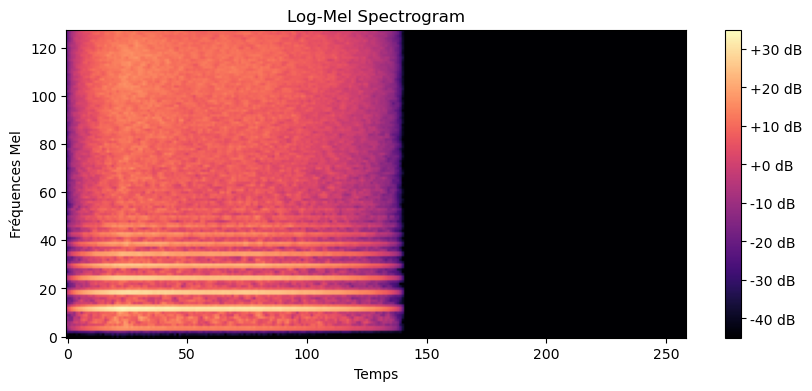

In [8]:
import torch
import torchaudio
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
TARGET_SAMPLE_RATE = 22050
TARGET_DURATION = 6.0
TARGET_SAMPLES = int(TARGET_SAMPLE_RATE * TARGET_DURATION)

def get_spectrogram(audio_path, target_sr, target_sample):
    waveform, sr = torchaudio.load(audio_path)

    # si le fichier n'est pas en 22050 Hz
    if sr != target_sr:
        resampler = torchaudio.transforms.Resample(sr, target_sr)
        waveform = resampler(waveform)

    # si le son est stéréo, on fait la moyenne des canaux
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)

    # gestion de la durée : sécurité
    num_samples = waveform.shape[1]
    
    if num_samples > target_sample:
        waveform = waveform[:, :target_sample]

    elif num_samples < target_sample:
        num_missing = target_sample - num_samples
        waveform = torch.nn.functional.pad(waveform, (0, num_missing))

    # Transformation en MelSpectrogram
    mel_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate = target_sr,
        n_mels = 128,
        n_fft = 2048,
        hop_length = 512
    )
    
    mel_spec = mel_transform(waveform)

    # Conversion en Decibels (Log scale)
    db_transform = torchaudio.transforms.AmplitudeToDB(top_db=80)
    mel_spec_db = db_transform(mel_spec)

    return mel_spec_db

# --- TEST ---
path_test = "wavs/sound_00438.wav" 
spec = get_spectrogram(path_test, TARGET_SAMPLE_RATE, TARGET_SAMPLES)

print(f"Forme du Spectrogramme : {spec.shape}") 

# Affichage
plt.figure(figsize=(10, 4))
plt.imshow(spec[0].numpy(), origin='lower', aspect='auto', cmap='magma')
plt.title("Log-Mel Spectrogram")
plt.ylabel("Fréquences Mel")
plt.xlabel("Temps")
plt.colorbar(format='%+2.0f dB')
plt.show()

In [9]:
class SynthDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, audio_dir, sr = 22050, duration = 6.0):
        self.df = pd.read_csv(csv_file)
        self.audio_dir = audio_dir
        self.sr = sr
        self.samples = int(sr * duration)

        self.mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate = sr,
            n_mels = 128,
            n_fft = 2048,
            hop_length = 512
        )
        self.db_transform = torchaudio.transforms.AmplitudeToDB(top_db=80)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        audio_filename = self.df.iloc[index, 0]
        audio_path = os.path.join(self.audio_dir, audio_filename)
        
        osc_type = int(self.df.iloc[index, 2])
        filter_type = int(self.df.iloc[index, 6])
        spectogram = get_spectrogram(audio_path, self.sr, self.samples)

        return spectogram, osc_type, filter_type

In [10]:
dataset = SynthDataset("logs/dataset_labels.csv", "wavs/")
image, osc, filter = dataset[0] # On teste le premier élément

print("Forme de l'image :", image.shape)
print("Label Osc :", osc)
print("Label Filtre :", filter)

Forme de l'image : torch.Size([1, 128, 259])
Label Osc : 4
Label Filtre : 1


In [11]:
import torch.nn as nn

class MultiTaskAudioCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.features = nn.Sequential(
            # Bloc 1
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # Bloc 2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Bloc 3
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Bloc 4
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )   # à la fin des couches, le volume de la donnée va être de 128 * (128/16) * (259/16) ~= 16384 valeurs
            # c'est ce nombre qui va dans ma couche Dense

        self.flat_size = 16384

        # Tête pour l'Oscillateur (Classification à 7 classes)
        self.osc_head = nn.Sequential(
            nn.Linear(self.flat_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 8)
        )

        # Tête pour le Filtre (Classification à 3 classes)
        self.filter_head = nn.Sequential(
            nn.Linear(self.flat_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 3)
        )

    def forward(self, x):
        """
        x : Tenseur d'entrée de forme [Batch_Size, 1, 128, Largeur]
        """

        x = self.features(x)
        x = x.view(x.size(0), -1)
        out_osc = self.osc_head(x)
        out_filter = self.filter_head(x)
        return out_osc, out_filter



In [12]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset

train_indices, test_indices = train_test_split(
    range(len(dataset)), 
    test_size=0.2, 
    random_state=42
)

train_set = Subset(dataset, train_indices)
test_set = Subset(dataset, test_indices)

print(f"Taille Train : {len(train_set)}")
print(f"Taille Test   : {len(test_set)}")

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

Taille Train : 8000
Taille Test   : 2000


In [13]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Calcul sur : {device}")

model = MultiTaskAudioCNN().to(device)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Calcul sur : cpu


In [14]:
num_epochs = 7  # Nombre de fois qu'il va voir tout le dataset

# Listes pour stocker l'historique (pour faire des graphiques plus tard)
history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc_osc': [],
    'val_acc_osc': []
}

print("Démarrage de l'entraînement...")

for epoch in range(num_epochs):
    
    # ==========================
    # 1. PHASE D'ENTRAÎNEMENT
    # ==========================

    model.train()
    running_loss = 0.0
    correct_osc = 0
    total_samples = 0
    
    for inputs, labels_osc, labels_filter in train_loader:
        # Envoi des données sur le GPU/CPU
        inputs = inputs.to(device)
        labels_osc = labels_osc.to(device)
        labels_filter = labels_filter.to(device)
        
        optimizer.zero_grad()
        
        out_osc, out_filter = model(inputs)
        
        loss_osc = loss(out_osc, labels_osc)
        loss_filter = loss(out_filter, labels_filter)
        total_loss = loss_osc + loss_filter
        
        # calcul des corrections
        total_loss.backward()
        
        # Optimisation
        optimizer.step()
        
        # stats pour le suivi
        running_loss += total_loss.item()
        
        # Calcul de la précision pour l'Oscillateur
        # torch.max renvoie (score_max, osc_pred). On veut l'oscillateur
        _, predicted_osc = torch.max(out_osc.data, 1)
        total_samples += labels_osc.size(0)
        correct_osc += (predicted_osc == labels_osc).sum().item()

    # Calcul des moyennes pour cette époque
    epoch_loss = running_loss / len(train_loader)
    epoch_acc_osc = 100 * correct_osc / total_samples
    history['train_loss'].append(epoch_loss)
    history['train_acc_osc'].append(epoch_acc_osc)
    

    # ==========================
    # 2. PHASE DE VALIDATION
    # ==========================

    model.eval()
    test_loss = 0.0
    correct_test_osc = 0
    total_test_samples = 0
    
    # torch.no_grad() accélère le calcul car on ne stocke pas les gradients
    with torch.no_grad():
        for inputs, labels_osc, labels_filter in test_loader:
            inputs = inputs.to(device)
            labels_osc = labels_osc.to(device)
            labels_filter = labels_filter.to(device)
            
            out_osc, out_filter = model(inputs)
            
            l_osc = loss(out_osc, labels_osc)
            l_filter = loss(out_filter, labels_filter)
            test_loss += (l_osc + l_filter).item()
            
            _, predicted_osc = torch.max(out_osc.data, 1)
            total_test_samples += labels_osc.size(0)
            correct_test_osc += (predicted_osc == labels_osc).sum().item()

    # Moyennes Validation
    avg_test_loss = test_loss / len(test_loader)
    avg_test_acc_osc = 100 * correct_test_osc / total_test_samples
    history['val_loss'].append(avg_test_loss)
    history['val_acc_osc'].append(avg_test_acc_osc)

    # Affichage
    print(f"Epoch [{epoch+1}/{num_epochs}] "
        f"Train Loss: {epoch_loss:.4f} | Test Loss: {avg_test_loss:.4f} | "
        f"Acc Osc (Train): {epoch_acc_osc:.2f}% | Acc Osc (Val): {avg_test_acc_osc:.2f}%")

print("Entraînement terminé !")

Démarrage de l'entraînement...
Epoch [1/7] Train Loss: 3.0250 | Test Loss: 2.2034 | Acc Osc (Train): 17.31% | Acc Osc (Val): 22.80%
Epoch [2/7] Train Loss: 2.1745 | Test Loss: 1.9380 | Acc Osc (Train): 21.62% | Acc Osc (Val): 30.40%
Epoch [3/7] Train Loss: 2.0044 | Test Loss: 1.9197 | Acc Osc (Train): 26.85% | Acc Osc (Val): 29.35%
Epoch [4/7] Train Loss: 1.8538 | Test Loss: 1.6532 | Acc Osc (Train): 31.02% | Acc Osc (Val): 41.75%
Epoch [5/7] Train Loss: 1.7100 | Test Loss: 1.5018 | Acc Osc (Train): 35.40% | Acc Osc (Val): 45.55%
Epoch [6/7] Train Loss: 1.5986 | Test Loss: 1.3358 | Acc Osc (Train): 37.91% | Acc Osc (Val): 47.30%
Epoch [7/7] Train Loss: 1.5209 | Test Loss: 1.3239 | Acc Osc (Train): 39.89% | Acc Osc (Val): 50.00%
Entraînement terminé !


In [15]:
def predict_synth_params(audio_path, model):
    """
    Prend un fichier audio et retourne les paramètres prédits.
    """
    model.eval()
    
    spec = get_spectrogram(audio_path, TARGET_SAMPLE_RATE, TARGET_SAMPLES)
    spec = spec.unsqueeze(0).to(device)
    
    with torch.no_grad():
        out_osc, out_filter = model(spec)
        
        pred_osc_idx = torch.argmax(out_osc, 1).item()
        pred_filter_idx = torch.argmax(out_filter, 1).item()
        
    return pred_osc_idx, pred_filter_idx

OSC_MAP = {
    0: "Saw Up", 1: "Saw Down", 2: "Square", 
    3: "Triangle", 4: "Pulse", 5: "Bipolar Pulse", 
    6 : "Unknown", 7: "Modulated Sine"
}
FILTER_MAP = {0: "LowPass", 1: "HighPass", 2: "BandPass"}


# TEST
test_file = "sound_00087.wav" 
path_file = os.path.join("wavs", test_file)

osc_id, filter_id = predict_synth_params(path_file, model)

print(f"Fichier : {test_file}")
print("="*30)
print(f"Oscillateur prédit : {OSC_MAP[osc_id]}")
print(f"Filtre prédit      : {FILTER_MAP[filter_id]}")

# Vérification
df = pd.read_csv("logs/dataset_labels.csv")
row = df[df['filename'] == test_file].iloc[0]
print(f"\n--- VÉRITÉ ---")
print(f"Oscillateur réel   : {OSC_MAP.get(int(row['osc_type']))}")
print(f"Filtre réel        : {FILTER_MAP.get(int(row['filter_type']))}")

Fichier : sound_00087.wav
Oscillateur prédit : Modulated Sine
Filtre prédit      : HighPass

--- VÉRITÉ ---
Oscillateur réel   : Triangle
Filtre réel        : HighPass


In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

y_true_osc = []
y_pred_osc = []

y_true_filter = []
y_pred_filter = []

model.eval() 

print("Calcul des matrices de confusion en cours...")

with torch.no_grad():
    for inputs, labels_osc, labels_filter in test_loader:
        inputs = inputs.to(device)
        
        # Prédictions
        out_osc, out_filter = model(inputs)
        
        # On transforme les probas en entiers (Argmax)
        _, preds_osc = torch.max(out_osc, 1)
        _, preds_filter = torch.max(out_filter, 1)
        
        # On stocke tout sur le CPU pour Scikit-learn
        y_true_osc.extend(labels_osc.cpu().numpy())
        y_pred_osc.extend(preds_osc.cpu().numpy())
        
        y_true_filter.extend(labels_filter.cpu().numpy())
        y_pred_filter.extend(preds_filter.cpu().numpy())

print("Terminé !")

Calcul des matrices de confusion en cours...
Terminé !


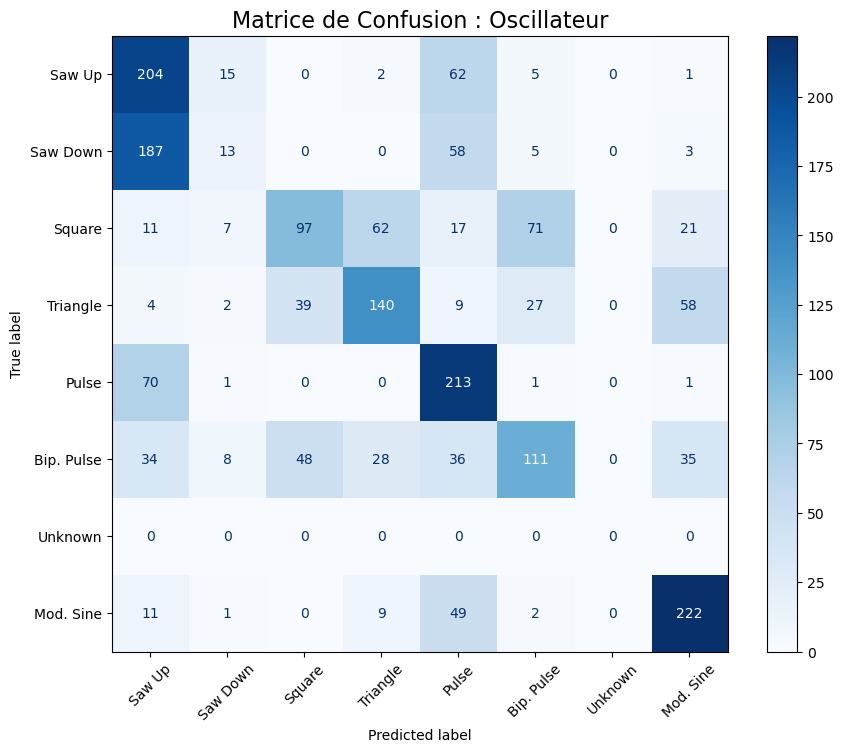

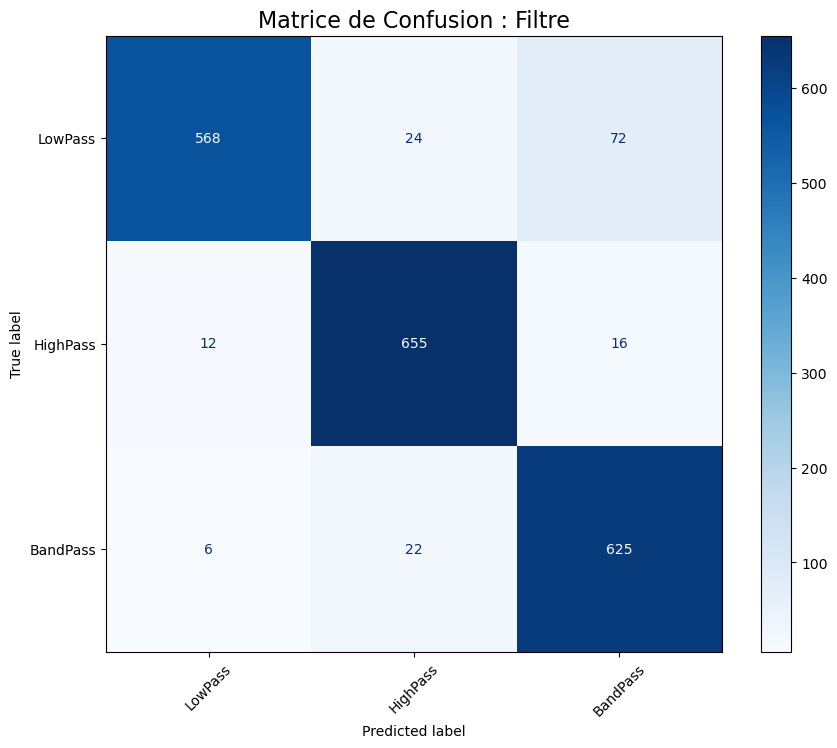

In [17]:
def plot_cm(y_true, y_pred, classes, title):
    # CORRECTION ICI : On force les labels de 0 à len(classes)-1
    # Cela garantit que la matrice a la même taille que la liste de noms
    # même si certaines classes sont absentes des données.
    nb_classes = len(classes)
    forced_labels = list(range(nb_classes)) 
    
    cm = confusion_matrix(y_true, y_pred, labels=forced_labels)
    
    # Création du graphique
    fig, ax = plt.subplots(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    
    # Affichage
    disp.plot(cmap='Blues', ax=ax, xticks_rotation=45)
    plt.title(title, fontsize=16)
    plt.show()

class_names_osc = [
    "Saw Up", "Saw Down", "Square", "Triangle", 
    "Pulse", "Bip. Pulse", "Unknown", "Mod. Sine"
]
class_names_filter = ["LowPass", "HighPass", "BandPass"]

plot_cm(y_true_osc, y_pred_osc, class_names_osc, "Matrice de Confusion : Oscillateur")
plot_cm(y_true_filter, y_pred_filter, class_names_filter, "Matrice de Confusion : Filtre")